In [1]:
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T


classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]


transformation = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

### Image preprocessing

In [2]:
def process(img_path):
    # reshape image to 32x32, convert to RGB color space
    return cv2.cvtColor(cv2.resize(cv2.imread(img_path), (32, 32)), cv2.COLOR_BGR2RGB)

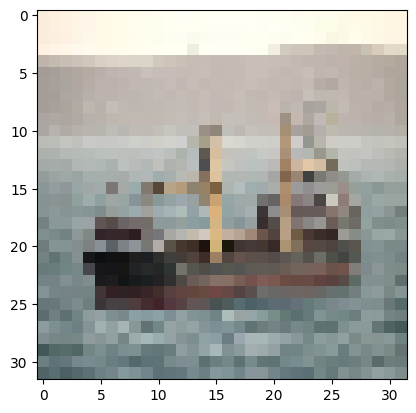

In [3]:
img = process("../test_data/ship/ship_2.jpg")
plt.imshow(img)
plt.show()

In [4]:
import torchvision

testset = torchvision.datasets.CIFAR10("../data", train=False, transform=transformation)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


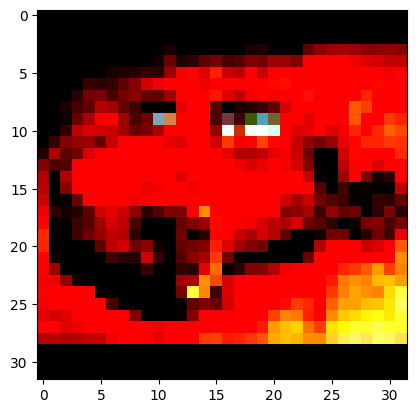

automobile


In [13]:
img, label = testset[4013]

plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.show()
print(classes[label])

### Predict the probability for each class

In [14]:
import torch
from model import ResNetCifar


# transform the image data and load the model
transformed_img = img.unsqueeze(0)
model = ResNetCifar(depth=110)
model.load_state_dict(torch.load("../model/resnet110.pt"))

# in this test case, we only have a single image
prob = model(transformed_img)[0]
print(prob)
print(classes[torch.argmax(prob)])

tensor([-0.4576, -0.3788,  0.2687,  0.6681,  0.0319,  0.4086, -0.1793,  0.0611,
        -0.3559, -0.0812], grad_fn=<SelectBackward0>)
cat


### Plot the predicted probability for each class

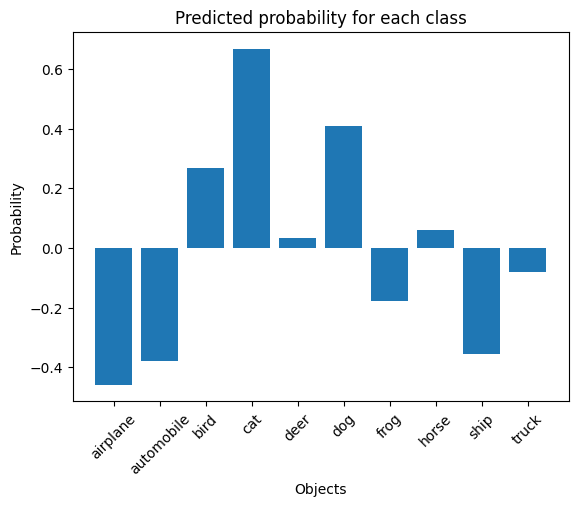

In [15]:
plt.bar(range(len(prob)), prob.detach().numpy())
plt.xticks(range(len(prob)), classes, rotation=45)
plt.xlabel("Objects")
plt.ylabel("Probability")
plt.title("Predicted probability for each class")
plt.show()
